# Interferometry Image Reconstruction

This notebook provides a minimal image reconstruction algorithm for interferometry.

Let $I(\alpha, \beta)$ be an image on the sky.
Interferometry allows astronomer to sample the Fourier transform of the image $\hat{I}(u, v) = \int\int I(\alpha,\beta) \exp[-2\pi i(u\alpha + v\beta)] d\alpha d\beta$ along the $uv$-tracks $[u_{ab}(t), v_{ab}(t)]$ for telescopes $a$ and $b$ at time $t$.

Given a small number of telescope locations, we have a sparse set of $uv$ tracks, which sample the Fourier transform of the image.
We call these sampled Fourier coefficients the visibility $V_{abj} = \hat{I}(u_{ab}(t_n), v_{ab}(t_n))$ for all $a$, $b$, and $n$.

The problem of interferometry image reconstruction is to receover the original sky image $I(\alpha, \beta)$ to the best we can, based on the visibility $\{V_{abj}\}$.

We will develop a minimal image reconstruction algorithm in this notebook.
To make the algorithm easier to understand, we will build it incrementally.
We start by importing some useful packages.
In addition to the standard packages, `ehtplot` provides modified `afmhot` colormaps including `afmhot_us`, `afmhot_10us`, etc.

In [1]:
from jax import config
config.update("jax_enable_x64", True)

from jax import numpy as np
import pandas as pd

from astropy    import units
from astropy.io import fits

import ehtplot # from https://github.com/liamedeiros/ehtplot
from matplotlib import pyplot as plt

## Sample Data: EHT 2017 M87*

We start by look at a sample data set from EHT's 2017 observation.
The (heavily) averaged data is provided in a simple CSV file.

In [2]:
df = pd.read_csv(
    "vis/SR1_M87_2017_095_hi_hops_netcal_StokesI.csv",
    skiprows=2,
    names=['t', 's1', 's2', 'u', 'v', 'amp', 'phase', 'sigma'])

We also compute the complex visbility and the "weight".

In [3]:
mask = df.v < 0

df.loc[mask, 'u']     *= -1
df.loc[mask, 'v']     *= -1
df.loc[mask, 'phase'] *= -1

df['V'] = df.amp * np.exp(1j * (np.array(df.phase) * np.pi / 180))
df['w'] = 1.0 / df.sigma

print(df.V)
print(df.w)

0      -0.006917+0.012507j
1       0.136019-0.013969j
2       0.591577-0.950759j
3      -0.013640+0.012420j
4       0.075689+0.117322j
               ...        
6453    0.310243+0.059955j
6454    0.040855+0.042377j
6455   -0.108554-0.002454j
6456    0.977469+0.554353j
6457   -0.012231-0.104216j
Name: V, Length: 6458, dtype: complex128
0       171.033435
1       201.306479
2       190.730862
3        22.433737
4        30.683656
           ...    
6453     32.841596
6454     11.075692
6455     22.745490
6456     10.884912
6457     34.742742
Name: w, Length: 6458, dtype: float64


and list all the sites during the observation:

In [4]:
print('Sites:', sorted(set(df.s1) | set(df.s2)))

Sites: ['AA', 'AP', 'AZ', 'JC', 'LM', 'PV', 'SM']


The standard visualizations include $(u,v)$ tracks and visibility amplitudes vs baseline distance plots.

In [5]:
def uvtracks(ax, df, lim=9e9):
    u = np.array(df['u'])
    v = np.array(df['v'])
    U = np.concatenate([u, -u])
    V = np.concatenate([v, -v])
    ax.scatter(U, V, marker='.')
    ax.set_xlabel(r'$u$ ($\lambda$)')
    ax.set_ylabel(r'$v$ ($\lambda$)')
    ax.set_xlim( lim,-lim)
    ax.set_ylim(-lim, lim)
    ax.set_aspect('equal')

def amp(ax, df, ylog=True):
    a = df['amp']
    u = np.array(df['u'])
    v = np.array(df['v'])
    d = np.sqrt(u*u + v*v)
    ax.scatter(d, a, marker='.')
    ax.set_xlabel(r'$(u,v)$ distance ($\lambda$)')
    ax.set_ylabel(r'Visibility amplitude $|V|$')
    if ylog:
        ax.set_yscale('log')

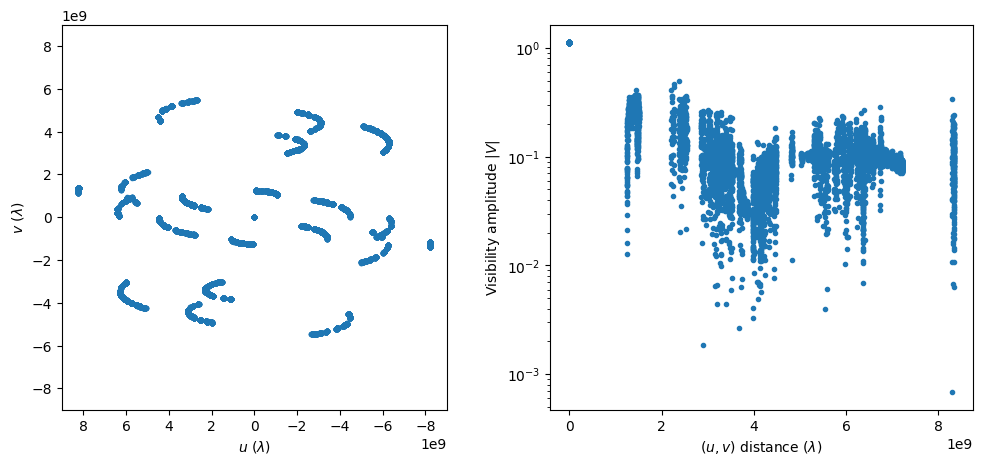

In [6]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
uvtracks(axes[0], df)
amp(axes[1], df)

## Sample Reconstruction: EHT 2017 M87*

We then look at a sample reconstruction from EHT's 2017 observation.
The `ehtim` reconstructed image is stored as a `fits` file.
We define a new class `Image` to store both the pixel values and the pixel dimensions.
We also define our own `imshow()` to plot the image.

In [7]:
class Image:
    def __init__(self, img, fov1=None, fov2=None):

        try:
            with fits.open(img) as hdul:
                self.p1 = hdul[0].header['CDElT1'] * units.degree.to(units.uarcsec)
                self.p2 = hdul[0].header['CDElT2'] * units.degree.to(units.uarcsec)
                self.I  = np.array(hdul[0].section[:,:]).T
        except:
            self.I = img

        if fov1 is None:
            self.fov1 = self.p1 * self.I.shape[0]
        else:
            self.fov1 = fov1

        if fov2 is None:
            self.fov2 = self.p2 * self.I.shape[1]
        else:
            self.fov2 = fov2

def imgshow(ax, img):
    h1 = img.fov1/2
    h2 = img.fov2/2
    ax.imshow(img.I.T, cmap='afmhot_10us', origin='lower', extent=[-h1,h1,-h2,h2])
    ax.set_xlabel(r'$\alpha$ ($\mu$as)')
    ax.set_ylabel(r'$\beta$ ($\mu$as)')
    ax.set_aspect(r'equal')

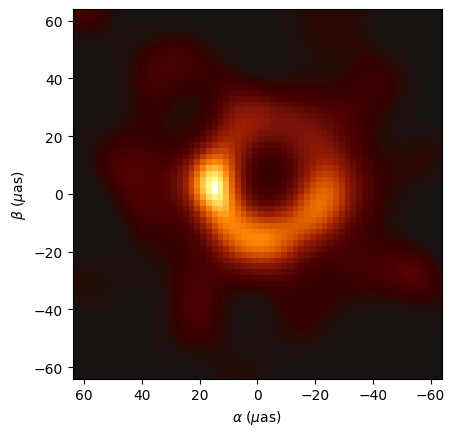

In [8]:
img = Image('img/3597_ehtim.fits')

fig, ax = plt.subplots(1,1)
imgshow(ax, img)

## Obtain Visibility from Image

To develop our own imaging algorithm, it is important to be able to transform between the image and visibility (Fourier) domain.
Because the image $I(\alpha,\beta)$ is real, its Fourier transform follow the Hermitian symmetry, i.e., $\hat{I}(-u,-v) = \hat{I}^*(u,v)$, where $^*$ denote complex conjugate.
To simplify optimization, we will use the "real" Fast Fourier Transform algorithm, which only returns half of the $(u,v)$ domain with $u >= 0$.

To avoid high frequency phase rotation, we move the itensity center near the "zeroth" element of the array.
To make plotting more convenient, we also move the origin of the $(u,v)$ domain to the "center".

In [9]:
def fft(img):
    return np.fft.fftshift(np.fft.rfft2(np.fft.fftshift(img, axes=(-2,-1)), norm='backward'), axes=-2)

def ifft(vis):
    return np.fft.fftshift(np.fft.irfft2(np.fft.fftshift(vis, axes=-2), norm='backward'), axes=(-2,-1))

The "pixel size" of the visibility is nothing but $1 / \mathrm{FOV}$ with $\mathrm{FOV}$ in radian.

In [10]:
class Visibility:
    def __init__(self, img):
        Usz = img.I.shape[-2] / img.fov1 / units.uarcsec.to(units.radian)
        Vsz = img.I.shape[-1] / img.fov2 / units.uarcsec.to(units.radian)
        
        self.I = fft(img.I)
        self.u = np.linspace(-Usz/2, Usz/2, endpoint=False, num=img.I.shape[-2])
        self.v = np.linspace(     0, Vsz/2, endpoint=True,  num=img.I.shape[-1]//2+1)

def visshow(ax, vis):
    u = vis.u
    v = vis.v
    ax.imshow(abs(vis.I.T), cmap='afmhot_10us', origin='lower', extent=[u[0],u[-1],v[0],v[-1]])
    ax.set_xlabel(r'$u$ ($\lambda$)')
    ax.set_ylabel(r'$v$ ($\lambda$)')
    ax.set_aspect(r'equal')

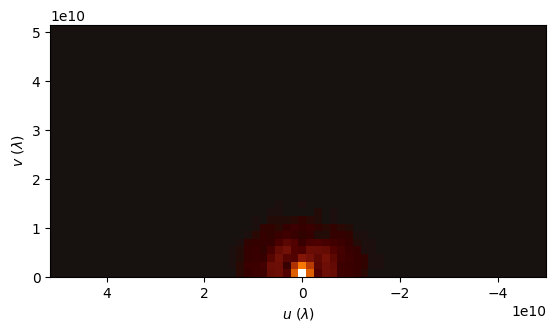

In [11]:
vis = Visibility(img)

fig, ax = plt.subplots(1,1)
visshow(ax, vis)

## Compare Visibility of the Constructed Image with the Data

We can now plot the visibility and its cross-sections.

Text(0, 0.5, '$v$ ($\\lambda$)')

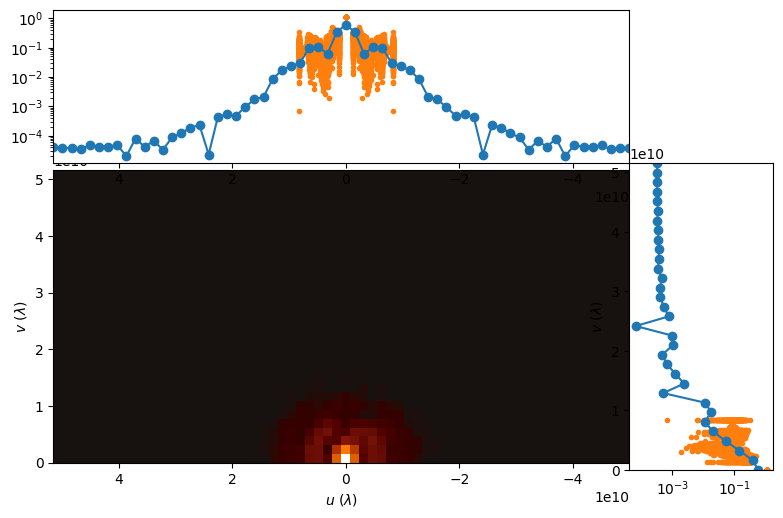

In [12]:
a = df['amp']
u = np.array(df['u'])
v = np.array(df['v'])
d = np.sqrt(u*u + v*v)

fig = plt.figure(figsize=(9,5.75))
gs  = fig.add_gridspec(
    2,2,
    width_ratios =(4,1), 
    height_ratios=(1,2),
    left=0.1, right=0.9, bottom=0.1, top=0.9,
    wspace=0, hspace=0)

ax       = fig.add_subplot(gs[1, 0])
ax_top   = fig.add_subplot(gs[0, 0], sharex=ax)
ax_right = fig.add_subplot(gs[1, 1], sharey=ax)

visshow(ax, vis)

ax_top.semilogy(vis.u, abs(vis.I[:,0]), 'o-')
ax_top.scatter(-d, a, marker='.', color='C1')
ax_top.scatter( d, a, marker='.', color='C1')

ax_right.semilogx(abs(vis.I[32,:]), vis.v, 'o-')
ax_right.scatter(a, d, marker='.', color='C1')
ax_right.set_ylabel(r'$v$ ($\lambda$)')

## Compare Visibility of a Mock Image with the Data

In [13]:
fov = 128 # uas
a   = np.linspace(-fov/2, fov/2, endpoint=False, num=16)
b   = np.linspace(-fov/2, fov/2, endpoint=False, num=16)
a,b = np.meshgrid(a, b)

img = Image(0.1 * (np.exp(-0.5 * (a*a + b*b) / (16*16)) - np.exp(-0.5 * (a*a + b*b) / (12*12))), fov1=fov, fov2=fov)
vis = Visibility(img)

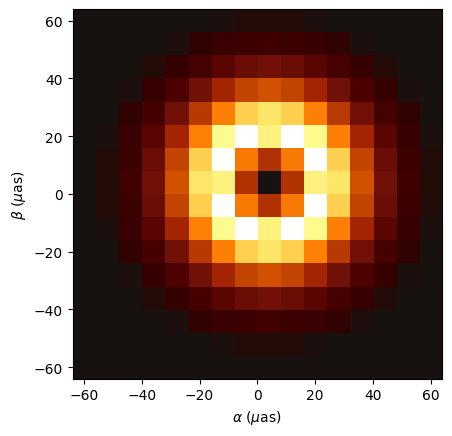

In [14]:
fig, ax = plt.subplots(1,1)
imgshow(ax, img)

Text(0, 0.5, '$v$ ($\\lambda$)')

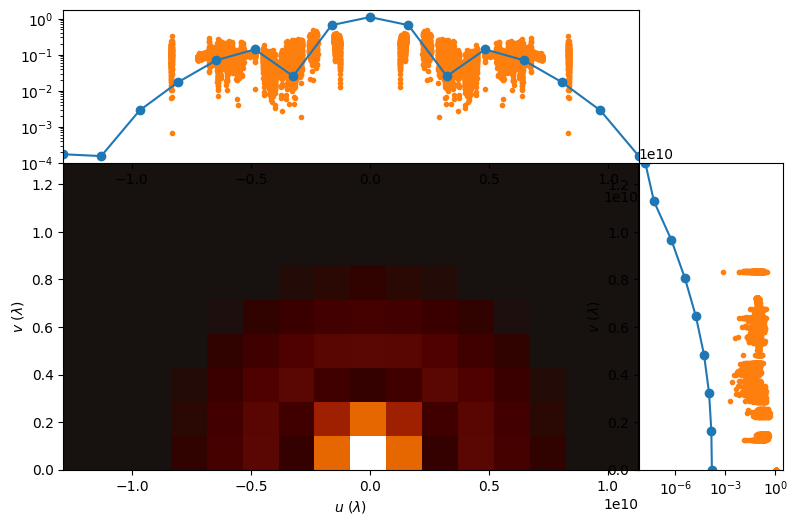

In [15]:
a = df['amp']
u = np.array(df['u'])
v = np.array(df['v'])
d = np.sqrt(u*u + v*v)

fig = plt.figure(figsize=(9,5.75))
gs  = fig.add_gridspec(
    2,2,
    width_ratios =(4,1), 
    height_ratios=(1,2),
    left=0.1, right=0.9, bottom=0.1, top=0.9,
    wspace=0, hspace=0)

ax       = fig.add_subplot(gs[1, 0])
ax_top   = fig.add_subplot(gs[0, 0], sharex=ax)
ax_right = fig.add_subplot(gs[1, 1], sharey=ax)

visshow(ax, vis)

ax_top.semilogy(vis.u, abs(vis.I[:,0]), 'o-')
ax_top.scatter(-d, a, marker='.', color='C1')
ax_top.scatter( d, a, marker='.', color='C1')

ax_right.semilogx(abs(vis.I[32,:]), vis.v, 'o-')
ax_right.scatter(a, d, marker='.', color='C1')
ax_right.set_ylabel(r'$v$ ($\lambda$)')

In [16]:
import numpy

V, U   = np.meshgrid(vis.v, vis.u)
Vis    = numpy.zeros(U.shape, dtype='complex')
Weight = numpy.zeros(U.shape)

for i, row in df.iterrows():
    du = row.u - U
    dv = row.v - V
    d  = np.sqrt(du*du + dv*dv)
    ij = np.unravel_index(d.argmin(), d.shape)
    Vis[*ij]    += row.V
    Weight[*ij] += row.w

Vis[Weight > 0] /= Weight[Weight > 0]
Vis = np.array(Vis)
Vis = fft(ifft(Vis))

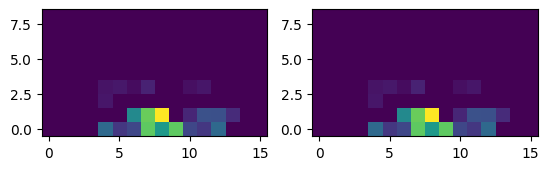

In [17]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(abs(Vis).T, origin='lower')
axes[1].imshow(abs(fft(ifft(Vis))).T, origin='lower')

In [18]:
Img = ifft(Vis)

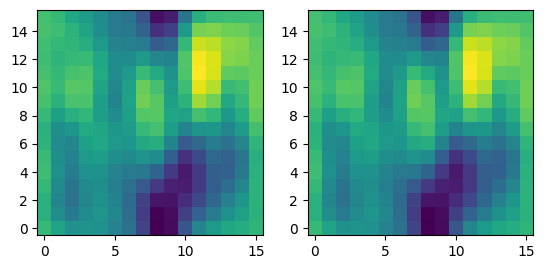

In [19]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(Img.T, origin='lower')
axes[1].imshow(ifft(fft(Img)).T, origin='lower')

In [20]:
from jax import jit, grad

def loss(img): # closure on Vis
    vis = fft(img)
    return (
        np.sum( # spectral domain
            + abs(vis - Vis)**2 # Data Term
        ) 
        + 
        np.sum( # image domain
            + np.maximum(-img, 0)**2 # non-negative
            + img * np.log(img)
        ) 
    )

g = jit(grad(loss))

100%|██████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 48345.15it/s]

0.007464463523954992 0.007705869179011887


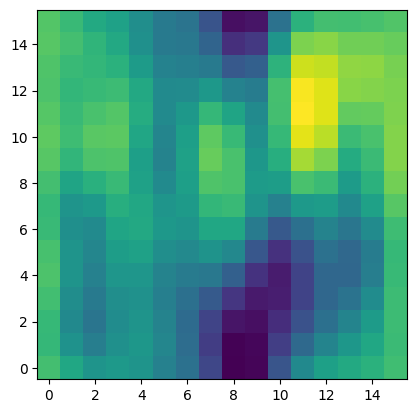

In [21]:
from tqdm import tqdm

Img = np.zeros(Img.shape) + 1
learning_rate = 0.001

for i in tqdm(range(10000)):
    Img -= learning_rate * g(Img)

print(np.min(Img), np.max(Img))
      
plt.imshow(Img.T, origin='lower')